# <center><font color=DarkRed> Partie 1 :Détectez les Bad Buzz grâce au Deep Learning</font></center><br>

<center>La société <font color=DarkBlue><b>Air-paradis</b></font>,est une compagnie aérienne qui n’a pas toujours bonne presse sur les réseaux</center>

<hr>

####**<center><font color=DarkRed>La mission :</font></center>**
En tant qu'Ingénieur IA chez MIC (Marketing Intelligence Consulting), une entreprise de conseil spécialisée sur les problématiques de marketing digital., **notre mission est de fournir à Mme Aline, directrice marketing de la compagnie aérienne “Air Paradis”**, un produit IA permettant d’anticiper les bad buzz sur les réseaux sociaux.

L'objectif de ce Notebook est de fournir **un prototype d’un produit IA permettant de prédire le sentiment associé à un tweet.** 

<font color=DarkBlue>**Par conséquent, nous fournirons à Mme Aline**</font> : 
- **Un prototype fonctionnel du modèle**. Le modèle envoie un tweet et récupère la prédiction de sentiment. 
-**Un support de présentation explicitant la méthodologie utilisée** pour l’approche “modèle sur mesure avancé” *(attention : audience non technique).*
- **Un article de blog de 800-1000 mots environ contenant une présentation et une comparaison des trois approches** *(“Modèle sur mesure simple” et “Modèle sur mesure avancé”, “Modèle avancé BERT”)*

<font color=DarkBlue>**Air paradis ne nous fournis pas de données**</font>, la solution est d'utiliser des données Open Source (ou en téléchargement direct à ce [Lien](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+7%C2%A0-+D%C3%A9tectez+les+Bad+Buzz+gr%C3%A2ce+au+Deep+Learning/sentiment140.zip))
- Description des données : des informations sur les tweets (utilisateur ayant posté, contenu, moment du post) et un label binaire (tweet exprimant un sentiment négatif ou non).
<hr>

La première étape consiste en l'**importation des librairies <code>Python</code>** nécessaires à l'analyse dans le <code>**Jupyter Notebook**</code> : <br>
- <code>**NumPy**</code>, 
- <code>**Pandas**</code>, 
- <code>**Matplotlib**</code>, 
- <code>**Seaborn**</code>, 
- <code>**Missingno**</code>,
- <code>**Sklearn**</code>.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importation des librairies

In [ ]:
!pip install unidecode
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 15.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 15.9 MB/s 
     |████████████████████████████████| 110 kB 46.4 MB/s 


In [ ]:
# Importer les librairies
import pandas as pd
from pathlib import Path
import re
import requests
from collections import Counter
import dateutil, datetime
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

%matplotlib inline

# Définir la configuration générale
pd.set_option("display.max_colwidth", 200)
# Contient 1.6M d'echantillons
PATH_DATA = "/content/drive/MyDrive/projet-7/data/training.csv"  #@param {type:"string"} 
LIMIT = 1600000  #@param {type:"number"} 




## Declaration des fonctions

In [ ]:
# Fonction qui renvoie la trame de données traitée
def loadDF(n_samples):
    
    # Lire
    df = pd.read_csv(
        PATH_DATA, 
        encoding = "latin", 
        header = None
    )
    
    # Supprimer les colonnes inutiles
    #df.drop(labels = [1,2,3,4], axis = "columns", inplace = True)
    df.columns = ['sentiment', 'id', 'date', 'flag', 'user', 'tweet']
    
    # relabelliser 0 -> 0 and 4 -> 1 (0:Negative, 1:Positive)
    df.replace(to_replace = 4, value = 1, inplace = True)

    # Définir la variable 'fuseau horaire'
    tzmap = {'PDT': dateutil.tz.gettz('US/Pacific')}

    # Convertir la chaîne PDT en date/heure (exécution d'environ 5 minutes)
    df['date'] = df['date'].apply(lambda x: dateutil.parser.parse(x, tzinfos=tzmap))
    
    # La formation sur 1,6 million d'échantillons prend beaucoup de temps, 
    # nous nous entraînons sur un sous-ensemble aléatoire plus petit des données
    df = df.sample(n = n_samples, random_state = 42)
    
    return df

def chat_words_conversion(text):

  with open("../content/drive/MyDrive/projet-7/data/myslang.json", "r") as file:
    chat_words_str = file.read()

  chat_words_map_dict = {}
  chat_words_list = []
  for line in chat_words_str.split("\n"):
      if line != "" and "=" in line:
          cw = line.split("=")[0]
          cw_expanded = line.split("=")[1]
          chat_words_list.append(cw)
          chat_words_map_dict[cw] = cw_expanded
  chat_words_list = set(chat_words_list)
  new_text = []
  for w in text.split():
      if w.upper() in chat_words_list:
          new_text.append(chat_words_map_dict[w.upper()])
      else:
          new_text.append(w)
  return " ".join(new_text)

In [ ]:
df = loadDF(LIMIT)
df.head()

,sentiment,id,date,flag,user,tweet
541200,0,2200003196,2009-06-16 18:18:12-07:00,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
750,0,1467998485,2009-04-06 23:11:14-07:00,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps for my razr 2"
766711,0,2300048954,2009-06-23 13:40:11-07:00,NO_QUERY,sammydearr,"@TiannaChaos i know just family drama. its lame.hey next time u hang out with kim n u guys like have a sleepover or whatever, ill call u"
285055,0,1993474027,2009-06-01 10:26:07-07:00,NO_QUERY,Lamb_Leanne,School email won't open and I have geography stuff on there to revise! *Stupid School* :'(
705995,0,2256550904,2009-06-20 12:56:51-07:00,NO_QUERY,yogicerdito,upper airways problem


## <center><font color=darkRed>1. - Présentation générale du jeu de données</font></center>

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600000 entries, 541200 to 121958
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype                                                   
---  ------     --------------    -----                                                   
 0   sentiment  1600000 non-null  int64                                                   
 1   id         1600000 non-null  int64                                                   
 2   date       1600000 non-null  datetime64[ns, tzfile('/usr/share/zoneinfo/US/Pacific')]
 3   flag       1600000 non-null  object                                                  
 4   user       1600000 non-null  object                                                  
 5   tweet      1600000 non-null  object                                                  
dtypes: datetime64[ns, tzfile('/usr/share/zoneinfo/US/Pacific')](1), int64(2), object(3)
memory usage: 85.4+ MB


In [ ]:
# Afficher les statistiques
df.describe(include='all')

<ipython-input-8-1dac92641988>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all')


,sentiment,id,date,flag,user,tweet
count,1600000.0,1.600000e+06,1600000,1600000,1600000,1600000
unique,NaN,NaN,774363,1,659775,1581466
top,NaN,NaN,2009-06-15 12:53:14-07:00,NO_QUERY,lost_dog,isPlayer Has Died! Sorry
freq,NaN,NaN,20,1600000,549,210
first,NaN,NaN,2009-04-06 22:19:45-07:00,NaN,NaN,NaN
last,NaN,NaN,2009-06-25 10:28:31-07:00,NaN,NaN,NaN
mean,0.5,1.998818e+09,NaN,NaN,NaN,NaN
std,0.5,1.935761e+08,NaN,NaN,NaN,NaN
min,0.0,1.467810e+09,NaN,NaN,NaN,NaN
25%,0.0,1.956916e+09,NaN,NaN,NaN,NaN


Synthèse

- **1,6 million** de tweets disponibles ;
- **AUCUNE** valeurs manquantes.
- 3 mois de tweet ont été collecter (avril 2009 à juin 2009) **la date n'est pas utile, je peux la supprimer**; 

- L'utilisateur *(lost_dog)* à envoyé **549 tweets en 3 mois** *(6 tweets par jour)*;
- Un même tweet revient **210 fois**

### <center><font color=darkRed>1.1 - Doublons</font></center># 

In [ ]:
df[df.tweet.str.contains('isPlayer Has Died! Sorry')]

,sentiment,id,date,flag,user,tweet
274956,0,1990705462,2009-06-01 05:32:56-07:00,NO_QUERY,wowlew,isPlayer Has Died! Sorry
102648,0,1795130733,2009-05-14 07:12:56-07:00,NO_QUERY,wowlew,isPlayer Has Died! Sorry
273545,0,1990421034,2009-06-01 04:49:33-07:00,NO_QUERY,wowlew,isPlayer Has Died! Sorry
99972,0,1793803394,2009-05-14 04:02:33-07:00,NO_QUERY,wowlew,isPlayer Has Died! Sorry
361274,0,2046807093,2009-06-05 12:43:15-07:00,NO_QUERY,wowlew,isPlayer Has Died! Sorry
...,...,...,...,...,...,...
273118,0,1990334525,2009-06-01 04:34:53-07:00,NO_QUERY,wowlew,isPlayer Has Died! Sorry
139881,0,1880905949,2009-05-22 02:55:29-07:00,NO_QUERY,wowlew,isPlayer Has Died! Sorry
290641,0,1995423965,2009-06-01 13:28:08-07:00,NO_QUERY,wowlew,isPlayer Has Died! Sorry
341373,0,2015025840,2009-06-03 03:28:11-07:00,NO_QUERY,wowlew,isPlayer Has Died! Sorry


**Le tweet <font color=DarkRed>(isPlayer Has Died! Sorry) de l'utilisateur @wowlew</font> à été dupliqué 210 fois**, 
je garde seulement la première valeur et je supprime les doublons.

Je supprime également les doublons avec les sous-ensembles "utilisateur + tweet"

In [ ]:
# Supprimer les doublons
df.drop_duplicates(subset=['user', 'tweet'], inplace=True)

# Supprimer la colonne date
df.drop(columns=['date'], inplace=True)

# Afficher les statistiques
df.describe(include='all')

,sentiment,id,flag,user,tweet
count,1.594745e+06,1.594745e+06,1594745,1594745,1594745
unique,NaN,NaN,1,659775,1581466
top,NaN,NaN,NO_QUERY,lost_dog,good morning
freq,NaN,NaN,1594745,549,114
mean,5.000241e-01,1.998936e+09,NaN,NaN,NaN
std,5.000002e-01,1.935947e+08,NaN,NaN,NaN
min,0.000000e+00,1.467810e+09,NaN,NaN,NaN
25%,0.000000e+00,1.956942e+09,NaN,NaN,NaN
50%,1.000000e+00,2.002137e+09,NaN,NaN,NaN
75%,1.000000e+00,2.177115e+09,NaN,NaN,NaN


## <center><font color=darkRed>2. - Analyse exploratoire des données</font></center>

### <center><font color=darkBlue>2.1 - Distribution des sentiments</font></center>

In [ ]:
df["sentiment"].value_counts()

1    797411
0    797334
Name: sentiment, dtype: int64

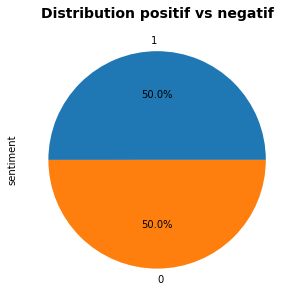

In [ ]:
plt.figure(figsize=(8,5))

df.sentiment.value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution positif vs negatif',
          fontsize=14, fontweight='bold')
plt.show()

- Il y a <font color=DarkRed>**798 150 tweets**</font> qui représentent <font color=DarkRed>**sentiments négatif**</font>;
- Il y a <font color=DarkGreen>**796 595 tweets**</font> qui représentent un <font color=DarkGreen>**sentiment positif**</font>.

*Il y a plus de sentiments négatif que positif*

In [ ]:
# Target correspondance
decode_map = {0: "NEGATIF", 2: "NEUTRE", 1: "POSITIF"}
def decode_sentiment(label):
    return decode_map[int(label)]

df['sentiment_string'] = df.sentiment.apply(lambda x: decode_sentiment(x))
display(df.head(3))

,sentiment,id,flag,user,tweet,sentiment_string
541200,0,2200003196,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!,NEGATIF
750,0,1467998485,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps for my razr 2",NEGATIF
766711,0,2300048954,NO_QUERY,sammydearr,"@TiannaChaos i know just family drama. its lame.hey next time u hang out with kim n u guys like have a sleepover or whatever, ill call u",NEGATIF


les mots les plus importants sont significatifs et pertinents en ce qui concerne le sentiment associé à chaque tweet

### <center><font color=darkBlue>2.2 - Distribution du nombres de mots par tweets</font></center>

In [ ]:
negative_tweet = df[df.sentiment == 0]
positive_tweet = df[df.sentiment == 1]

Longueur des tweets positifs - min :1, max :64, mean :13.0
Longueur des tweets négatifs - min :1, max :57, mean :14


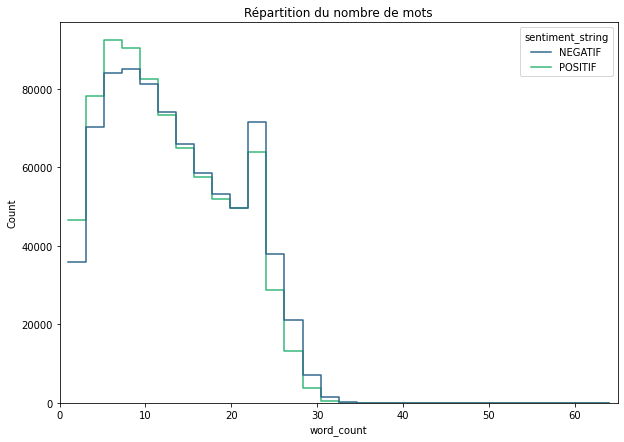

In [ ]:
tweet_neg = negative_tweet.tweet.str.split().str.len()
tweet_pos = positive_tweet.tweet.str.split().str.len()

print('Longueur des tweets positifs - min :{}, max :{}, mean :{}'.format(tweet_pos.min(),
                                                                   tweet_pos.max(),
                                                                   round(tweet_pos.mean(),0)))

print('Longueur des tweets négatifs - min :{}, max :{}, mean :{}'.format(tweet_neg.min(),
                                                                   tweet_neg.max(),
                                                                   round(tweet_neg.mean(),)))

df["word_count"] = df.tweet.str.split().str.len()

plt.figure(figsize=(10,7))
sns.histplot(data=df, x="word_count", hue="sentiment_string", bins=30, element="step", fill=False, palette='viridis')
plt.title("Répartition du nombre de mots")
plt.xlim([0, 65])
plt.show()

Class distribution:
POSITIF    797411
NEGATIF    797334
Name: sentiment_string, dtype: int64


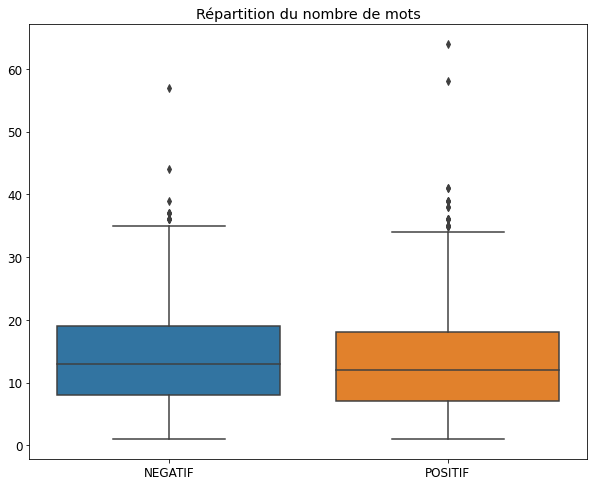

In [ ]:
print("Class distribution:\n{}".format(df["sentiment_string"].value_counts()))

# Check for null values
check = df.isnull().sum()
#print('null values : ',check)

#df['text_len'] = df['tweet'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 12})
sns.boxplot(x = 'sentiment_string', y = 'word_count', data =df)
plt.title("Répartition du nombre de mots")
plt.ylabel('')
plt.xlabel('');

Il n'y a pas de grandes différences dans le nombre de mots contenu dans les tweets positifs et négatifs.   

Cependant on remarque que **les tweets positifs ont un peu plus de mots que les tweets négatifs.**

le nombre maximum de mots est de 64 *(certainement due à la limitation de la longueur des tweets)*

### <center><font color=darkBlue>2.3 - Top 10 des utilisateurs par type de tweet (positif vs négatif)</font></center>

In [ ]:
negative_tweet = df[df.sentiment == 0]
positive_tweet = df[df.sentiment == 1]

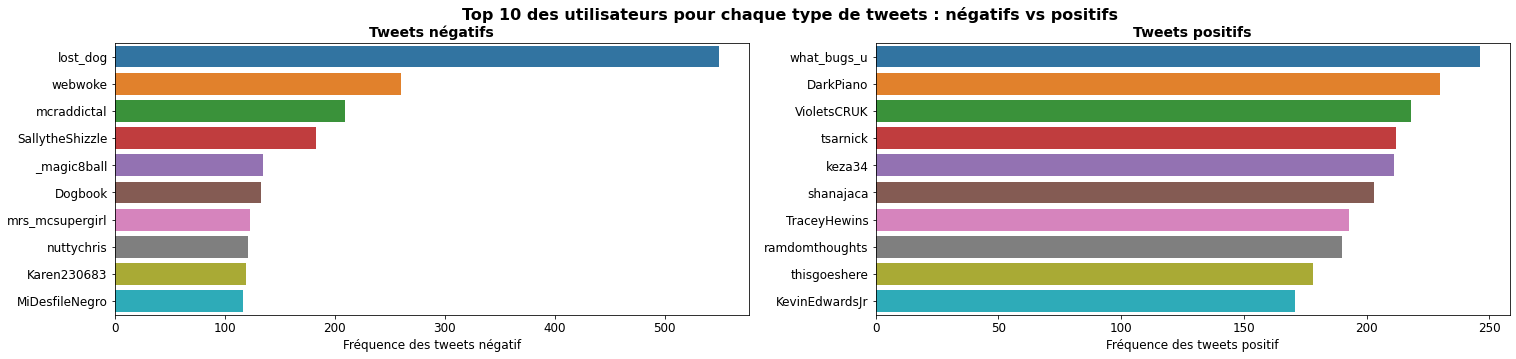

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,5))

neg_key = sns.barplot(y=negative_tweet.user.value_counts()[:10].index,
                      x=negative_tweet.user.value_counts()[:10].values,
                      ax=ax1)
neg_key.set_xlabel('Fréquence des tweets négatif', fontsize=12)
ax1.set_title('Tweets négatifs', fontsize=14, fontweight='bold')

pos_key = sns.barplot(y=positive_tweet.user.value_counts()[:10].index,
                      x=positive_tweet.user.value_counts()[:10].values,
                      ax=ax2)
pos_key.set_xlabel('Fréquence des tweets positif', fontsize=12)
ax2.set_title('Tweets positifs', fontsize=14, fontweight='bold')
plt.suptitle('Top 10 des utilisateurs pour chaque type de tweets : négatifs vs positifs',
             fontsize=16, fontweight='bold')
plt.show()

On remarque que l'utilisateur **lost_dog** produit le plus de tweet negatif et à l'inverse **what_bugs_u** produit le plus de commentaire positif

In [ ]:
print(negative_tweet[negative_tweet.user == 'lost_dog'].shape)
negative_tweet[negative_tweet.user == 'lost_dog'].head(5)

(549, 7)


,sentiment,id,flag,user,tweet,sentiment_string,word_count
47949,0,1677752995,NO_QUERY,lost_dog,@LOSTPETUSA I am lost. Please help me find a good home.,NEGATIF,11
762648,0,2297989146,NO_QUERY,lost_dog,@ecphelps I am lost. Please help me find a good home.,NEGATIF,11
221254,0,1976791217,NO_QUERY,lost_dog,@lainabeaar I am lost. Please help me find a good home.,NEGATIF,11
286499,0,1993926584,NO_QUERY,lost_dog,@LaMonteG I am lost. Please help me find a good home.,NEGATIF,11
199411,0,1971430810,NO_QUERY,lost_dog,@NicaNoelle I am lost. Please help me find a good home.,NEGATIF,11


L'utilisateur **lost_dog** a ecrit le meme message à 549 utilisateurs differents

In [ ]:
print(positive_tweet[positive_tweet.user == 'what_bugs_u'].shape)
positive_tweet[positive_tweet.user == 'what_bugs_u'].head(5)

(246, 7)


,sentiment,id,flag,user,tweet,sentiment_string,word_count
1141626,1,1977198277,NO_QUERY,what_bugs_u,"@cadmiumcannibal why limit your story to 140 ch. Tell all what is annoying you at www.iamsoannoyed.com ,it will help relieve your stress",POSITIF,22
1457424,1,2063580255,NO_QUERY,what_bugs_u,@ciarrapants why limit your story to 140 ch. Tell all what is annoying you at www.iamsoannoyed.com,POSITIF,16
1436240,1,2060957488,NO_QUERY,what_bugs_u,@emrosetownsend why limit your story to 140 ch. Tell all what is annoying you at www.iamsoannoyed.com,POSITIF,16
1490955,1,2069006478,NO_QUERY,what_bugs_u,@alyscharles why limit your story to 140 ch. Tell all what is annoying you at www.iamsoannoyed.com,POSITIF,16
1459230,1,2063735665,NO_QUERY,what_bugs_u,@jonanders why limit your story to 140 ch. Tell all what is annoying you at www.iamsoannoyed.com,POSITIF,16


L'utilisateur **what_bugs_u** a ecrit le meme message à 246 utilisateurs differents, le message a l'air de s'apparenter à de la publicité pour un site web.

## <center><font color=darkRed>3. - Préprocessing des tweets</font></center>

### <center><font color=darkBlue>3.1 - Nettoyage du dataset</font></center>

Avant de proceder au nettoyage, j'affiche les mots les plus frequents pour les commentaire positif et négatif à l'aide de nuage de mot *(wordcloud)*

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


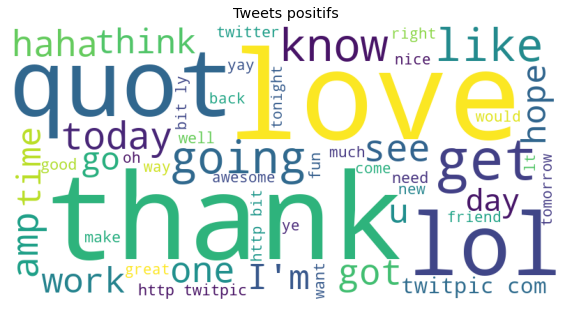

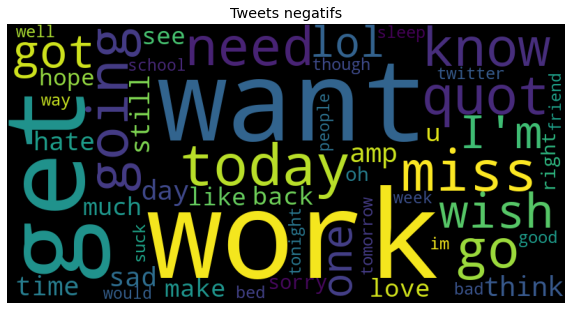

In [ ]:
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

df_pos = df.loc[df["sentiment"] == 1]
df_neg = df.loc[df["sentiment"] == 0]

wc_pos = WordCloud(
    stopwords = stopwords,
    width = 800, 
    height = 400,
    max_words=50,
    background_color="white"
).generate(" ".join(df_pos["tweet"])) 

wc_neg = WordCloud(
    stopwords = stopwords,
    width = 800, 
    height = 400,
    max_words=50,
    background_color="black"
).generate(" ".join(df_neg["tweet"])) 

plt.figure(figsize = (10,10))
plt.imshow(wc_pos)
plt.title("Tweets positifs")
plt.axis("off")
plt.show()

plt.figure(figsize = (10,10))
plt.imshow(wc_neg)
plt.title("Tweets negatifs")
plt.axis("off")
plt.show()

In [ ]:
n_sw = 50 #@param {type:"number"}
top_pos = list(wc_pos.words_.keys()) # Trié par ordre décroissant les fréquences, len=200
top_neg = list(wc_neg.words_.keys())
common = list(set(top_pos[:n_sw]) & set(top_neg[:n_sw]))
print(common)

['time', 'want', 'going', 'like', 'get', 'tonight', 'go', 'work', 'quot', 'make', 'oh', 'love', 'think', 'twitter', 'see', 'today', 'would', 'right', 'friend', 'well', 'need', 'u', 'one', 'know', 'got', 'day', 'tomorrow', 'lol', 'hope', 'good', 'back', 'much', "I'm", 'way', 'amp']


#### <center><font color=darkGreen>3.1.1 - Lemmatisation</font></center>

Pour le nettoyage du texte, je commence par transformer le texte en minuscule ensuite je supprime : 
- les mentions (@username), les URLs, les hashtags
- la ponctuation

Je remplace les contractions des mots par les séquences de mots correspondantes :  
*Les contractions sont des mots ou des combinaisons de mots qui sont raccourcis en supprimant des lettres et en les remplaçant par une apostrophe.*

Je remplace les mots abrégé style sms par les sequences de mots correpondantes.

Je garde les stopwords car ils contiennent des informations importantes sur le sens de la phrase

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
import string
from nltk.stem import SnowballStemmer
from unidecode import unidecode
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from gingerit.gingerit import GingerIt
import contractions

lem = True #@param {type:"boolean"}
lowercase = True #@param {type:"boolean"}
remove_mentions= True #@param {type:"boolean"}
remove_punctuations = True #@param {type:"boolean"}
contraction = True #@param {type:"boolean"}
conversion_sms = True #@param {type:"boolean"}
remove_common = False #@param {type:"boolean"}
stem = False #@param {type:"boolean"}
stop_words = False #@param {type:"boolean"}

puncs = string.punctuation
sw = nltk.corpus.stopwords.words('english')
#sw = stopwords.words("english") # Not used as it contains "don't" "not" "did't" which are "negative" and will change the meaning of the sentence
sb = SnowballStemmer(language = "english") # Mieux et plus rapide que PorterStemmer
# https://stackoverflow.com/questions/10554052/what-are-the-major-differences-and-benefits-of-porter-and-lancaster-stemming-alg
import json

with open('../content/drive/MyDrive/projet-7/data/ShortendText.json','r') as file:
    Abbr_dict=json.loads(file.read())

def preprocess(text):

    # Convertir en minuscule
    if lowercase is True:
        text = text.lower()

    if conversion_sms is True:
      text = chat_words_conversion(text)

    if remove_mentions is True:
        # Supprimer les mentions (@username), les URLs, les hashtags.  (\S+ correspond à tout ce qui n'est pas un espace)
        text = re.sub("@\S+", "user", text)
        text = re.sub("http\S+|https\S+", "url", text)
        text = re.sub("#", "", text)

    if remove_punctuations is True:
        # Supprimer les ponctuations (étape redondante, gérée ultérieurement dans le tokenizer Keras)
        text = text.translate(str.maketrans('', '', puncs))
        text = re.sub('[0-9]+', '', text)

    if contraction is True:
      # Développez toutes les contractions anglaises pour garder
      #le sens et en particulier le mot "not" qui pourrait être essentiel pour détecter un sentiment négatif
      text = contractions.fix(text)
    
    # Supprimer les accents (convertir en ascii)
    text = unidecode(text)

    # Tokenize
    tokenized_text = word_tokenize(text)

    if stem is True:
        tokenized_text = [sb.stem(doc) for doc in tokenized_text]
    # lemmatizer 
    if lem is True:
        lemmatizer = WordNetLemmatizer()
        tokenized_text = [lemmatizer.lemmatize(doc) for doc in tokenized_text]

    if stop_words is True:
        tokenized_text = [lemmatizer.lemmatize(doc) for doc in tokenized_text if doc not in stopwords]
        
    # NE PAS supprimer les mots vides car ils contiennent des informations important sur le sens de la phrase et des jetons non alphanumériques
    if remove_common is True:
        tokenized_text = [t for t in tokenized_text if t.isalnum() and t not in common]
    tokenized_text  = " ".join(tokenized_text)
    return tokenized_text

from tqdm import tqdm
tqdm.pandas()

In [ ]:
def cleanDF(df):
    df['lem_tweet'] = df['tweet'].progress_apply(lambda x : preprocess(x))
    return df

In [ ]:
# Cela prend beaucoup de temps
df = cleanDF(df)
display(df)

100%|██████████| 1594745/1594745 [1:00:09<00:00, 441.86it/s]


,sentiment,id,flag,user,tweet,sentiment_string,word_count,lem_tweet
541200,0,2200003196,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!,NEGATIF,6,user ahhh i hope your ok
750,0,1467998485,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps for my razr 2",NEGATIF,12,user cool i have no tweet apps for my razr
766711,0,2300048954,NO_QUERY,sammydearr,"@TiannaChaos i know just family drama. its lame.hey next time u hang out with kim n u guys like have a sleepover or whatever, ill call u",NEGATIF,27,user i know just family drama it lamehey next time you hang out with kim n you guy like have a sleepover or whatever ill call you
285055,0,1993474027,NO_QUERY,Lamb_Leanne,School email won't open and I have geography stuff on there to revise! *Stupid School* :'(,NEGATIF,16,school email will not open and i have geography stuff on there to revise stupid school
705995,0,2256550904,NO_QUERY,yogicerdito,upper airways problem,NEGATIF,3,upper airway problem
...,...,...,...,...,...,...,...,...
259178,0,1985361990,NO_QUERY,lutheasalom,this song's middle change just doesn't want to be born..... arghhhh!!,NEGATIF,11,this song middle change just doe not want to be born arghhhh
1414414,1,2057029784,NO_QUERY,beeluz,@officialnjonas Good luck with that,POSITIF,5,user good luck with that
131932,0,1835639354,NO_QUERY,lordmuttley,@ProudGamerTweet I rather average 32370,NEGATIF,5,user i rather average
671155,0,2246780174,NO_QUERY,MizSadittyFancy,Pickin up @misstinayao waitin on @sadittysash 2 hurry up...I odeeee missed dem Table talk 2nite...LOL bout to be fat...,NEGATIF,19,pickin up user waitin on user hurry upi odeeee missed dem table talk nitelol bout to be fat


#### <center><font color=darkGreen>3.1.3 - Stemming</font></center>

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
import string
from nltk.stem import SnowballStemmer
from unidecode import unidecode
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from gingerit.gingerit import GingerIt
import contractions

lem = False #@param {type:"boolean"}
lowercase = True #@param {type:"boolean"}
remove_mentions= True #@param {type:"boolean"}
remove_punctuations = True #@param {type:"boolean"}
contraction = True #@param {type:"boolean"}
conversion_sms = True #@param {type:"boolean"}
remove_common = False #@param {type:"boolean"}
stem = True #@param {type:"boolean"}
stop_words = False #@param {type:"boolean"}

puncs = string.punctuation
sw = nltk.corpus.stopwords.words('english')
#sw = stopwords.words("english") # Not used as it contains "don't" "not" "did't" which are "negative" and will change the meaning of the sentence
sb = SnowballStemmer(language = "english") # Mieux et plus rapide que PorterStemmer
# https://stackoverflow.com/questions/10554052/what-are-the-major-differences-and-benefits-of-porter-and-lancaster-stemming-alg
import json

with open('../content/drive/MyDrive/projet-7/data/ShortendText.json','r') as file:
    Abbr_dict=json.loads(file.read())

def preprocess(text):

    # Convertir en minuscule
    if lowercase is True:
        text = text.lower()

    if conversion_sms is True:
      text = chat_words_conversion(text)

    if remove_mentions is True:
        # Supprimer les mentions (@username), les URLs, les hashtags.  (\S+ correspond à tout ce qui n'est pas un espace)
        text = re.sub("@\S+", "user", text)
        text = re.sub("http\S+|https\S+", "url", text)
        text = re.sub("#", "", text)

    if remove_punctuations is True:
        # Supprimer les ponctuations (étape redondante, gérée ultérieurement dans le tokenizer Keras)
        text = text.translate(str.maketrans('', '', puncs))
        text = re.sub('[0-9]+', '', text)

    if contraction is True:
      # Développez toutes les contractions anglaises pour garder
      #le sens et en particulier le mot "not" qui pourrait être essentiel pour détecter un sentiment négatif
      text = contractions.fix(text)
    
    # Supprimer les accents (convertir en ascii)
    text = unidecode(text)

    # Tokenize
    tokenized_text = word_tokenize(text)

    if stem is True:
        tokenized_text = [sb.stem(doc) for doc in tokenized_text]
    # lemmatizer 
    if lem is True:
        lemmatizer = WordNetLemmatizer()
        tokenized_text = [lemmatizer.lemmatize(doc) for doc in tokenized_text]

    if stop_words is True:
        tokenized_text = [lemmatizer.lemmatize(doc) for doc in tokenized_text if doc not in stopwords]
        
    # NE PAS supprimer les mots vides car ils contiennent des informations important sur le sens de la phrase et des jetons non alphanumériques
    if remove_common is True:
        tokenized_text = [t for t in tokenized_text if t.isalnum() and t not in common]
    tokenized_text  = " ".join(tokenized_text)
    return tokenized_text

from tqdm import tqdm
tqdm.pandas()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def cleanDF(df):
    df['stem_tweet'] = df['tweet'].progress_apply(lambda x : preprocess(x))
    return df

In [ ]:
# Cela prend beaucoup de temps
df = cleanDF(df)
display(df)

100%|██████████| 1594745/1594745 [1:03:53<00:00, 415.98it/s]


,sentiment,id,flag,user,tweet,sentiment_string,word_count,lem_tweet,lem_SW_tweet,stem_tweet
0,0,2200003196,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!,NEGATIF,6,user ahhh i hope your ok,user ahhh hope ok,user ahhh i hope your ok
1,0,1467998485,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps for my razr 2",NEGATIF,12,user cool i have no tweet apps for my razr,user cool tweet apps razr,user cool i have no tweet app for my razr
2,0,2300048954,NO_QUERY,sammydearr,"@TiannaChaos i know just family drama. its lame.hey next time u hang out with kim n u guys like have a sleepover or whatever, ill call u",NEGATIF,27,user i know just family drama it lamehey next time u hang out with kim n u guy like have a sleepover or whatever ill call u,user know family drama lamehey next time u hang kim n u guy like sleepover whatever ill call u,user i know just famili drama it lamehey next time you hang out with kim n you guy like have a sleepov or whatev ill call you
3,0,1993474027,NO_QUERY,Lamb_Leanne,School email won't open and I have geography stuff on there to revise! *Stupid School* :'(,NEGATIF,16,school email wont open and i have geography stuff on there to revise stupid school,school email wont open geography stuff revise stupid school,school email will not open and i have geographi stuff on there to revis stupid school
4,0,2256550904,NO_QUERY,yogicerdito,upper airways problem,NEGATIF,3,upper airway problem,upper airway problem,upper airway problem
...,...,...,...,...,...,...,...,...,...,...
1594740,0,1985361990,NO_QUERY,lutheasalom,this song's middle change just doesn't want to be born..... arghhhh!!,NEGATIF,11,this song middle change just doesnt want to be born arghhhh,song middle change doesnt want born arghhhh,this song middl chang just doe not want to be born arghhhh
1594741,1,2057029784,NO_QUERY,beeluz,@officialnjonas Good luck with that,POSITIF,5,user good luck with that,user good luck,user good luck with that
1594742,0,1835639354,NO_QUERY,lordmuttley,@ProudGamerTweet I rather average 32370,NEGATIF,5,user i rather average,user rather average,user i rather averag
1594743,0,2246780174,NO_QUERY,MizSadittyFancy,Pickin up @misstinayao waitin on @sadittysash 2 hurry up...I odeeee missed dem Table talk 2nite...LOL bout to be fat...,NEGATIF,19,pickin up user waitin on user hurry upi odeeee missed dem table talk nitelol bout to be fat,pickin user waitin user hurry upi odeeee missed dem table talk nitelol bout fat,pickin up user waitin on user hurri upi odeee miss dem tabl talk nitelol bout to be fat


### <center><font color=darkBlue>3.2 - Enregistrer le dataset</font></center>

In [ ]:
# sauvegarder le csv
df.to_csv('/content/drive/MyDrive/projet-7/data/final_df.csv', index=False)